# Advanced Lane Finding

In [1]:
import glob

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import random

from math import isinf

from moviepy.editor import *
from IPython.display import HTML
# Camera Calibration parameters
_FOLDER_CALIBRATION_ = "camera_cal/"
calib_array = glob.glob(_FOLDER_CALIBRATION_ + "*.jpg")
chess_cols, chess_rows = 9,6
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
mtx = []
dist = []

# Parameters
_FOLDER_TEST_IMG_ = "test_images/"
testfiles = glob.glob(_FOLDER_TEST_IMG_ + "*.jpg")

# Video Filenames
_PROJECT_VIDEO_ = "project_video.mp4"
_CHALLENGE_ = "challenge_video.mp4"
_HARDER_ = "harder_challenge_video.mp4"

## Camera Calibration

To calibrate the camera, I am using a method that consists on generating a transformation matrix comparing a known pattern to pictures taken with the camera. In this case, we are using pictures of a chessboard pattern taken from different angles in real world coordinates (x,y,z) and we want a projection on the z-plane (x,y,0).

OpenCV comes with the method "calibrateCamera" that, by feeding it with an array of images, manages to compute the transformation matrix. Once we have it, we can apply the method "undistort" to do the camera correction.

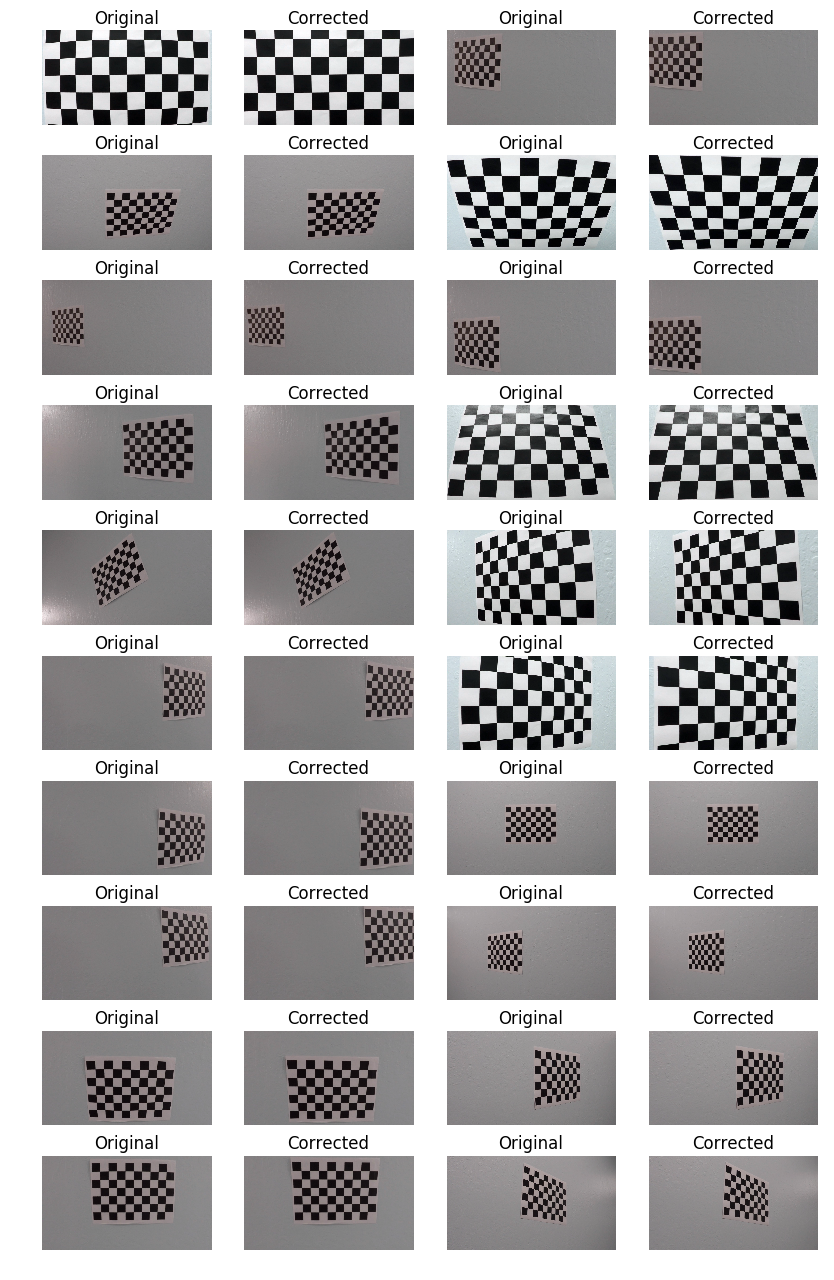

In [2]:
# Set object points [(0,0,0), (1,0,0,), ..., (chess_cols-1,chess_rows-1,0)]
objp = np.zeros((chess_cols*chess_rows, 3), np.float32)
objp[:,:2] = np.mgrid[0:chess_cols,0:chess_rows].T.reshape(-1,2)

# Create arrays to store both object coordinates (3D) and image coordinates (2D)
objpoints = []
imgpoints  = []

for fname in calib_array:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (chess_cols, chess_rows), None)
    
    if ret:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Display correction
plt.figure(figsize=(10,32))
for i in range(len(calib_array)):
    img = cv2.imread(calib_array[i])
    dst = cv2.undistort(img,mtx,dist,None,mtx)

    plt.subplot2grid((len(calib_array), 4),(i%10, 0 + 2*(int)(i/10))).set_title("Original")
    plt.axis('off')
    plt.imshow(img)
    
    plt.subplot2grid((len(calib_array), 4),(i%10, 1 + 2*(int)(i/10))).set_title("Corrected")
    plt.axis('off')
    plt.imshow(dst)
plt.show()

As stated before, we will use this transformation to compensate for camera aberration in the main pipeline. The correction becames specially noticable in the corners of the image.

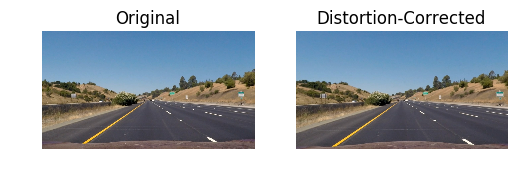

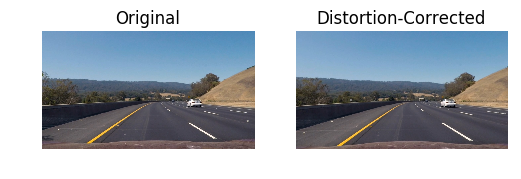

In [3]:
selection = [10,14]
for index in selection:
    image = cv2.imread(testfiles[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(image,mtx,dist,None,mtx)
    plt.figure()
    plt.subplot(121).set_title("Original")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(122).set_title("Distortion-Corrected")
    plt.imshow(undistorted)
    plt.axis('off')
    plt.show()

## Binarization: Color and Gradient Thresholding
To generate a binary image, I am using a combination of thresholds on different color spaces and gradients.

First of all, the saturation channel on the HLS colorspace tend to provide us with an image where the lane lines stand out. That happens because the lines tend to be white or a light color, hence max saturation.

Sometimes, the saturation channel is not enough to highlight orange lines, specially in bright images. In this case, be can use a combination of the blue chroma and red chroma of the YCbCr color space to make them stand out as orange is defined to be maximum red choma and minimum blue chroma. To be more precise, we are using the normalized diference between the normalized Cb channel and the normalized Cr channel.

By normalizing the image, impose that the maximum value of the image must be 255 and the minimum is 0. This helps us deal with the variation between images.

We are also using the luminance (Y) channel of the YCbCr colorspace to compute both x and y gradients using the Sobel method. Since a direct grayscale conversion comes with some data loss, in the YCbCr, Cb and Cr carry all color related data and the luminance layer gives us similar data as a grayscale but instead of doing a raw conversion, we get it by disregarding the color data.

In [4]:
sobel_min = 50
sobel_max = 100

sat_min = 210

In [5]:
def Normalize(image):
    output = (image - image.min())/(image.max() - image.min())
    return 255*output

def Binarize(image):
    # The saturation channel gives us a good differentiation for the lines
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] 
    
    # As grayscale image, we will use the brightes channel of the YCbCr
    # colorspace after linear normalization
    ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    gray = Normalize(ycbcr[:,:,0])
    
    #cb = Normalize(ycbcr[:,:,1])
    cb = Normalize(ycbcr[:,:,1]) - Normalize(ycbcr[:,:,2])
    cb = Normalize(cb)
    cb[cb<160] = 0
    cb[cb>0] = 1
    
    # Sobel x
    xSobel = np.abs(cv2.Sobel(gray, cv2.CV_64F,1,0))
    xSobel = Normalize(xSobel)
    
    # Sobel y
    ySobel = np.abs(cv2.Sobel(gray, cv2.CV_64F,0,1))
    ySobel = Normalize(xSobel)
    
    # Binarization
    sobelXBinary = np.zeros_like(xSobel)
    sobelXBinary[ ((xSobel > sobel_min) & ( xSobel < sobel_max))] = 1
    sobelYBinary = np.zeros_like(ySobel)
    sobelYBinary[ ((ySobel > sobel_min) & ( ySobel < sobel_max))] = 1
    
    satBinary = np.zeros_like(s_channel)
    satBinary[gray > sat_min] = 1
    
    output = np.zeros_like(s_channel)
    output[(satBinary == 1) | ((sobelXBinary == 1) & (sobelYBinary == 1)) | (cb == 1)] = 1
    
    return output

This are some examples of binarization, incuding images taken directly from one of the more challenging videos.

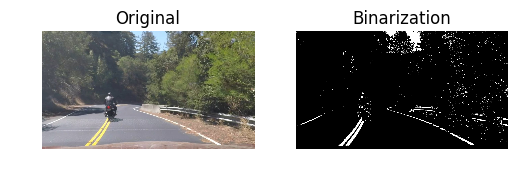

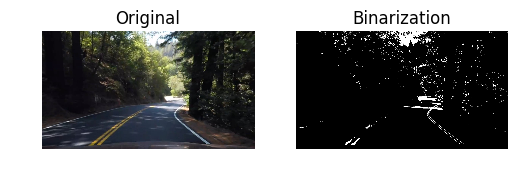

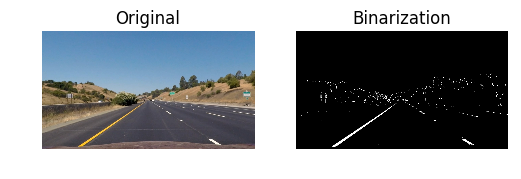

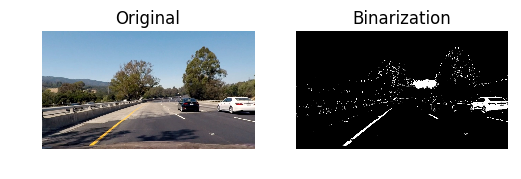

In [18]:
selection = [2,5,10,15]
for index in selection:
    image = cv2.imread(testfiles[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.undistort(image,mtx,dist,None,mtx)
    output = Binarize(image)
    
    plt.figure()
    plt.subplot(121).set_title("Original")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(122).set_title("Binarization")
    plt.imshow(output, cmap='gray')
    plt.axis('off')
    plt.show()

## Perspective Transform

Next, I am extending a trapezoidal piece of the image as a full image to compensate for the perspective of the image and, thus, get better aproximations of the lines while. To get the perspective transformation I hardcoded the edges of the trapezoid by taking into account a given image of a straight lane and the destination edges.

<table>
<tr><th>Source</th><th>Destination</th></tr>
<tr><td>[252, 675]</td><td>[240, 720]</td></tr>
<tr><td>[545,480]</td><td>[240, 0]</td></tr>
<tr><td>[740, 480]</td><td>[1040, 0]</td></tr>
<tr><td>[1060, 675]</td><td>[1040, 720]</td></tr>
</table>

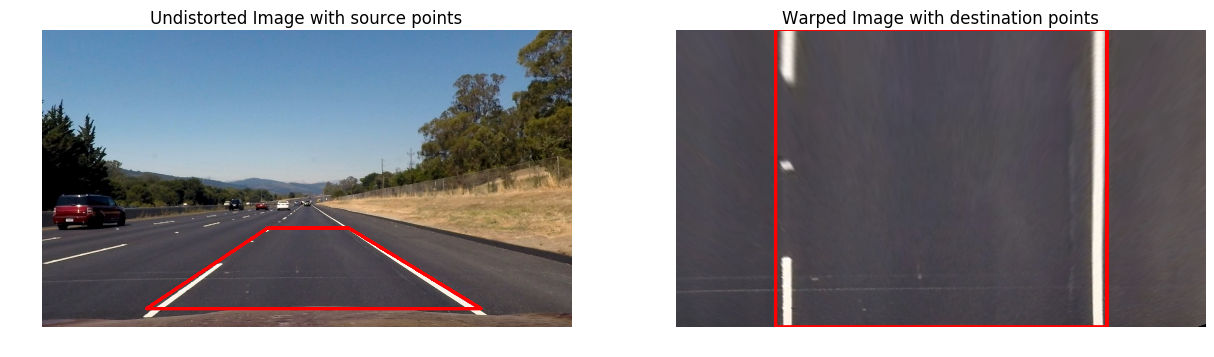

In [7]:
# Load Reference Image and apply camera correction
# We are assuming that the image shows a straight lane
image = cv2.imread(testfiles[11])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
source = cv2.undistort(image,mtx,dist,None,mtx)

# Define a trapezoid in the source image and its equivalent
# after the transformation
src = np.float32([ [252, 675], [545,480], [740, 480], [1060, 675] ])
dst = np.float32([ [240, 720], [240, 0], [1040, 0], [1040, 720] ])

# Get Transformation Matrix and Inverse
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(source, M,  source[:,:,0].shape[::-1])

plt.figure(figsize=(15,8))
plt.subplot(121).set_title("Undistorted Image with source points")
plt.axis('off')
plt.imshow(cv2.polylines(source.copy(),np.int32([src]), 1, (255,0,0), 8)) 

plt.subplot(122).set_title("Warped Image with destination points")
plt.axis('off')
plt.imshow(cv2.polylines(warped,np.int32([dst]), 1, (255,0,0), 8))
plt.show()

## Line Extraction

To find the lane lines, a valid strategy is to look for peaks in the histogram of the projected undistorted binarized image and then use sliding windows to refine that result.

Essentially, I start by summing all values of the lower half of the image along the horizontal axis. Since the image is binary, a high value on the sum indicates a high density of ones in that zone and I am assuming that means there is a lane there.

Now that I have a rough idea of were I can find the lines, I will refine the results by searching smaller blocks. Starting in the lower part of the image, I place a window at the points we found using the histogram and look for a local peak there. 

Then, I move the window up one step and center it using the previous found peak and repeat the process until I reach the top of the image.

Once I have all the blocks, I try to fit a quadratic equation.

In [8]:
# Line Extraction Parameters
margin = 100
minpix = 50

nwindows = 12

In [9]:
def GetLinesFirstIteration(binary, nonzerox, nonzeroy):
    # Create a histogram of the lower half of the image
    histogram = np.sum(binary[binary.shape[0]/2:,:], axis=0)
    window_height = np.int(binary.shape[0]/nwindows) 
    
    # Divide the space into two
    midpoint = np.int(histogram.shape[0]/2)
    leftx = np.argmax(histogram[:midpoint])
    rightx = histogram.shape[0] - np.argmax(histogram[:midpoint])

    curr_left = leftx
    curr_right = rightx

    left_idx = []
    right_idx = []

    for window in range(nwindows):
        # Set the window boundary
        y_low = binary.shape[0] - (window+1)*window_height
        y_high = binary.shape[0] - window*window_height
        left_low = curr_left - margin
        left_high = curr_left + margin
        right_low = curr_right - margin
        right_high = curr_right + margin

        # search for non-zero pixels in the window
        good_left_idx = ( (nonzeroy >= y_low) & (nonzeroy < y_high) &
                         (nonzerox >= left_low) & (nonzerox < left_high)
        ).nonzero()[0]

        good_right_idx = ( (nonzeroy >= y_low) & (nonzeroy < y_high) &
                         (nonzerox >= right_low) & (nonzerox < right_high)
        ).nonzero()[0]

        left_idx.append(good_left_idx)
        right_idx.append(good_right_idx)

        # Recenter the window for the next iteration 
        if len(good_left_idx) > minpix:
            curr_left = np.int(np.mean(nonzerox[good_left_idx]))
        if len(good_right_idx) > minpix:        
            curr_right = np.int(np.mean(nonzerox[good_right_idx]))

    left_idx = np.concatenate(left_idx)
    right_idx = np.concatenate(right_idx)
    
    return left_idx, right_idx

def GetLines(binary, left_fit = None, right_fit = None):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if ((left_fit == None) & (right_fit == None)):
        left_idx, right_idx = GetLinesFirstIteration(binary, nonzerox, nonzeroy)
    else:
        left_idx = (
            (nonzerox > (left_fit[0]*(nonzeroy**2)) + left_fit[1]*nonzeroy + left_fit[2] - margin) &
            (nonzerox < (left_fit[0]*(nonzeroy**2)) + left_fit[1]*nonzeroy + left_fit[2] + margin)
        )
        right_idx = (
            (nonzerox > (right_fit[0]*(nonzeroy**2)) + right_fit[1]*nonzeroy + right_fit[2] - margin) &
            (nonzerox < (right_fit[0]*(nonzeroy**2)) + right_fit[1]*nonzeroy + right_fit[2] + margin)
        )

    xLeft = nonzerox[left_idx]
    yLeft = nonzeroy[left_idx]
    xRight = nonzerox[right_idx]
    yRight = nonzeroy[right_idx]

    return xLeft, yLeft, xRight, yRight

def GetCurvature(a,b,y):
    return ((1+(2*a*y + b)**2)**(1.5))/np.abs(2*a)

def IsValid(lane_width, rLeft, rRight):
    output = True
    
    if (lane_width < 4.0) | (lane_width > 6.0):
        output = False
    
    log = np.log(rLeft)/np.log(rRight)
    if (log < 0.8) | (log > 1.25):
        output = False
    
    return output

This is an example of the line extraction and posterior fitting of a quadratic equation to predict the lane limits

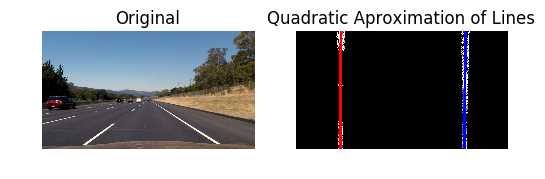

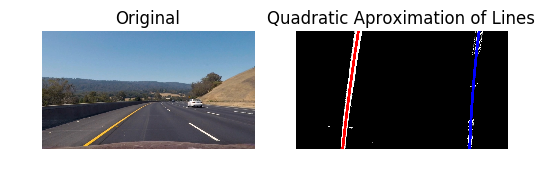

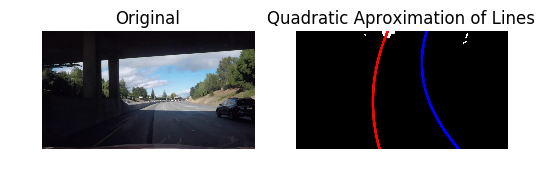

In [16]:
selection = [11,14,18]
for index in selection:
    image = cv2.imread(testfiles[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.undistort(image,mtx,dist,None,mtx)
    binary_source = Binarize(image)
    binary = cv2.warpPerspective(binary_source, M,  binary_source.shape[::-1])
    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    
    xLeft, yLeft, xRight, yRight= GetLines(binary)
    
    left_fit = np.polyfit(yLeft, xLeft, 2)
    right_fit = np.polyfit(yRight, xRight, 2)
    
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]  
    
    leftLine_points = np.vstack((left_fitx,ploty)).transpose()
    rightLine_points = np.vstack((right_fitx,ploty)).transpose()
    bw = np.uint8(np.dstack((binary,binary,binary))*255 )
    
    bw = cv2.polylines(bw, np.int32([leftLine_points]),0,[255,0,0],16)
    bw = cv2.polylines(bw, np.int32([rightLine_points]),0,[0,0,255],16)
    
    plt.figure()
    plt.subplot(121).set_title("Original")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(122).set_title("Quadratic Aproximation of Lines")
    plt.imshow(bw, cmap='gray')
    plt.axis('off')
    plt.show()

## Support Class: Line
First of all, to make the processing of the video easier, I created a custom class for a lane line that stores the history of coeficients of 10 samples and records if the line has been found in the previous iteration.

To smooth the transition on each iteration and compensate for steps where the line was not found, I keep a record of the last coeficients of the quadratic fits. If the line is found, I insert a new entry in the history and delete the oldest one and, then, I make the final prediction using the mean over all the values stored.



In [11]:
# Image to Reality conversions
yPix2m = 30/720
xPix2m = 3.7/700

class Line:
    found = False
    history = np.empty((0,3))
    
    def InsertLineCoefs(self, coefs):
        if (self.history.shape[0] > 10):
            self.history = np.delete(self.history,0,0)
        
        self.history = np.vstack((self.history, np.array([coefs])))
        
    def GetLineCoefs(self):
        output = np.array([0,0,640])
        if (len(self.history > 0)):
            output = self.history.mean(axis=0)
            
        return output

## Image Processing

The image processing uses the quadratic fit that I discussed before, compute the position and curvature, performs a series of validations and, finally, we make a final prediction.

### Vehicle Position and Curvature
If we have obtained more than two points for a given line, we apply a linear transformation to project those coordinates to aproximate real world metrics. Then we try to fit a quadratic equationg using these "real world" coordinates and, using that aproximation, compute the horizontal position of the line in the lowest part of the image and get the line curvature.

If we didn't find a valid line, we assume curvature 0 and fit to the appropiate vertical side of the image. Essentially, we are assuming that the line is out of sight.

To compute the position of the vehicle we compute the mean of both horizontal positions and compare it to the center of the image:

position = 0.5 * (left_lane + right_line) - 0.5*image_width
(all in "real world" coordinates)

If the position is negative, it means that the vehicle is left of the center and if it's positive, the vehicle is leaning to the right.

Similarly, I compute the lane width by substracting the left line position to the right line position in "real world" coordinates.

### Validation
Now that we have the vehicle position, the lane width, the curvature and a quadratic fit for both lines, I can check that the metrics make sense.

First, I will consider the results invalid if the lane width is lesser than 3m or over 7m. 

I will also consider the result invalid if the second degree parameter of both fits are too different (the division is lesser than -7 or over 10). That parameter determines the curvature of the fit and if they are hugely different, it might indicate that what we found is erroneous. Specially if the sign of both is different as it indicates that both equations have diferent concavity.

Finally, in a similar matter, we will use the curvature of both lines to perform a final validation. The problem with the curvatures is that in a straight lane, the value might suffer huge variations due to tiny errors of measure. Therfore, to determine its validity, I will use the division of both logarithms. 

### Final Prediction
As stated before, if I have found a valid approximation, I feed the fit parameters to the line class of each line and set the found property to true. On the other hand, if I have an invalid approximation, there is no new data fed to the line class and both found properties are set to false.

To perform the final prediction for each line, I use the mean of each parameter over the last 10 valid fittings and, then, I display the polygon over the original image.

In [21]:
def ImageProcessing(image):
    global leftLine
    global rightLine
    
    # Preprocess
    source = cv2.undistort(np.uint8(image),mtx,dist,None,mtx)
    binary_source = Binarize(source)     
    binary = cv2.warpPerspective(binary_source, M,  binary_source.shape[::-1])
    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    
    if (leftLine.found) & (rightLine.found):
        xLeft, yLeft, xRight, yRight= GetLines(binary, leftLine.history[-1], rightLine.history[-1])
    else:
        xLeft, yLeft, xRight, yRight= GetLines(binary)
    
    # Verify Results sanity
    # First, we need to compute the real world quadratic fit for both lines
    
    # Left Line
    if (len(xLeft) <= 5):
        # Left line not found
        #print("Not enough left points")
        left_curvature = 0
        left_position = 0
        left_top = 0
    else:
        # if line found, get curvature and the position of the left lane at the bottom
        # of the image (car plane). 
        left_fit = np.polyfit(yLeft*yPix2m, xLeft*xPix2m, 2)
        y = source.shape[0]*yPix2m
        left_curvature = GetCurvature(left_fit[0],left_fit[1],y)
        left_position = left_fit[0] * (y**2) + left_fit[1] * y + left_fit[2]
        
        y = 0.5*source.shape[0]*yPix2m
        left_top = left_fit[0] * (y**2) + left_fit[1] * y + left_fit[2]
    
    if (len(xRight) <= 5):
        # Right line not found
        #print("Not enough right points")
        right_curvature = 0
        right_position = source.shape[1]*xPix2m
        right_top = source.shape[1]*xPix2m
    else:
        # if line found, get curvature and the position of the right lane at the bottom
        # of the image (car plane). 
        right_fit = np.polyfit(yRight*yPix2m, xRight*xPix2m, 2)
        y = source.shape[0]*yPix2m
        right_curvature = GetCurvature(right_fit[0],right_fit[1],y)
        right_position = right_fit[0] * (y**2) + right_fit[1] * y + right_fit[2]  
        
        y = 0.5*source.shape[0]*yPix2m  
        right_top = right_fit[0] * (y**2) + right_fit[1] * y + right_fit[2]  
        
    lane_width = right_position - left_position
    center = 0.5*(right_position+left_position) - 0.5*source.shape[1]*xPix2m
    
    valid = True
    # Is the lane width reasonable?
    if (lane_width < 3) | (lane_width > 7):
        # the lane width is not adecuate
        valid = False
        
    # Check curvatures
    #print(right_fit[0] / left_fit[0])
    if (right_curvature > 0) & (left_curvature > 0):
        # Both lines are in frame
        ratio = right_fit[0] / left_fit[0]
        if (ratio < -7) | (ratio>10):
            # Lines have different concavity (one turns left, the other right)
            valid = False
            
        # As curvatures can be very different, especially if we are in a straight lane
        # we will use their log as a sanity measure
        log = np.log(left_curvature)/np.log(right_curvature)
        #print(log)
        if (log < 0.6) | (log > 1.8):
            #print("Invalid curvature: {}".format((int)(log*1000)/1000))
            valid = False
    
    # Check if lines cross
    if (right_top < left_top):
        valid = False
    
    # Update Lines if valid
    if (valid) & (len(xLeft) > 5):
        left_fit = np.polyfit(yLeft, xLeft, 2)
        leftLine.found = True
        leftLine.InsertLineCoefs(left_fit)
        
    else:
        leftLine.found = False
        
    if (valid) & (len(xRight) > 5):
        right_fit = np.polyfit(yRight, xRight, 2)
        rightLine.found = True
        rightLine.InsertLineCoefs(right_fit)
        
    else:
        rightLine.found = False
    
    left_fit = leftLine.GetLineCoefs()
    right_fit = rightLine.GetLineCoefs()
    
    # Convert fit to lines (both for image and to compute the curvature)
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
        
    # Display Infromation
    # reshape line data 
    leftLine_points = np.vstack((left_fitx,ploty)).transpose()
    rightLine_points = np.vstack((right_fitx,ploty)).transpose()

    # reverse perspective transformation for lines
    leftLine_unw = cv2.perspectiveTransform(np.array([leftLine_points]), Minv)
    rightLine_unw = cv2.perspectiveTransform(np.array([rightLine_points]), Minv)

    # combine lines to create the lane filling
    polyLine = np.vstack( (leftLine_unw[0], rightLine_unw[0,::-1] ))

    # Create a mask with the lane graphics and add it to the source image
    mask = np.zeros_like(source)

    mask = cv2.fillPoly(mask,np.int32([polyLine]),[0,255,0])
    mask = cv2.polylines(mask, np.int32(leftLine_unw),0,[255,0,0],16)
    mask = cv2.polylines(mask, np.int32(rightLine_unw),0,[0,0,255],16)
    
    #bw = np.uint8(np.dstack((binary,binary,binary))*255 )
    
    output = cv2.addWeighted(source, 1, mask, 0.4, 0)
    
    # Add informative text
    displayText1 = "R. Left: {}m, R. Right: {}m".format( (int)(left_curvature), (int)(right_curvature) )
    displayText2 = "Center Offset: {}m, Lane width: {}m".format(
        (int)(100*center)/100, (int)(100*lane_width)/100
    ) 
    
    output = cv2.putText(output, displayText1, (20,50), cv2.FONT_HERSHEY_DUPLEX, 1, [255,255,100],1)
    output = cv2.putText(output, displayText2, (20,100), cv2.FONT_HERSHEY_DUPLEX, 1, [255,255,100],1)

    return output

Here are some exaples of the output:

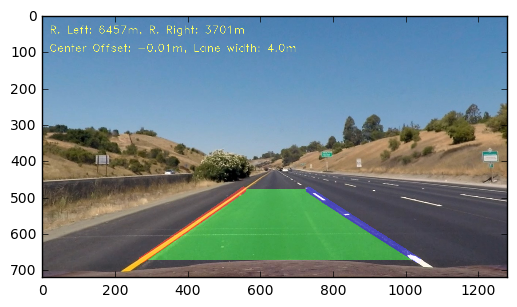

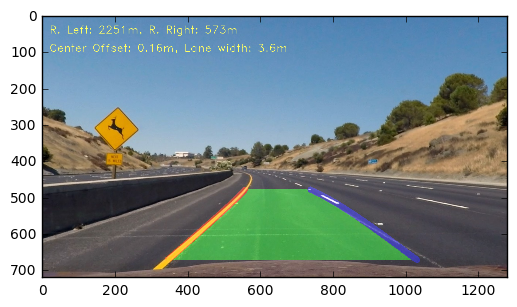

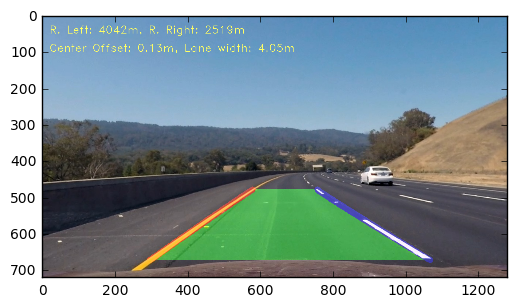

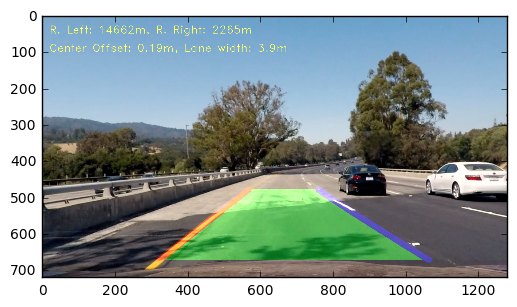

In [22]:
selection = [10,13,14,15]
for index in selection:
    global leftLine
    global rightLine
    
    leftLine = Line()
    rightLine = Line()
    
    image = cv2.imread(testfiles[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = ImageProcessing(image)
    plt.figure()
    plt.imshow(output)
    plt.show()

## Video Processing

In [23]:
global leftLine
global rightLine

leftLine = Line()
rightLine = Line()

str_clip = _CHALLENGE_
challenge_output = 'out_'+str_clip

clip2 = VideoFileClip(str_clip)
challenge_clip = clip2.fl_image(ImageProcessing)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:21<00:00,  6.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 

Wall time: 1min 22s


## Discussion

The program works fairly well on the requested video but doesn't perform as well in the harder challenges. 

To keep improving the program, I think I should start by exploring more about the color spaces and linear transformations of the image that might help me get more robust binarizations of the image that better isolate the lane lines.

It would probably be useful to try compute the perspective transformation on runtime by trying to aproximate the horizon line as it would help accomodate changes on the slope of the road.

It would also be interesting to further explore the validation criteria for the lines as it would help filter bad aproximations generated in non-ideal frames. 